## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
import os

In [2]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

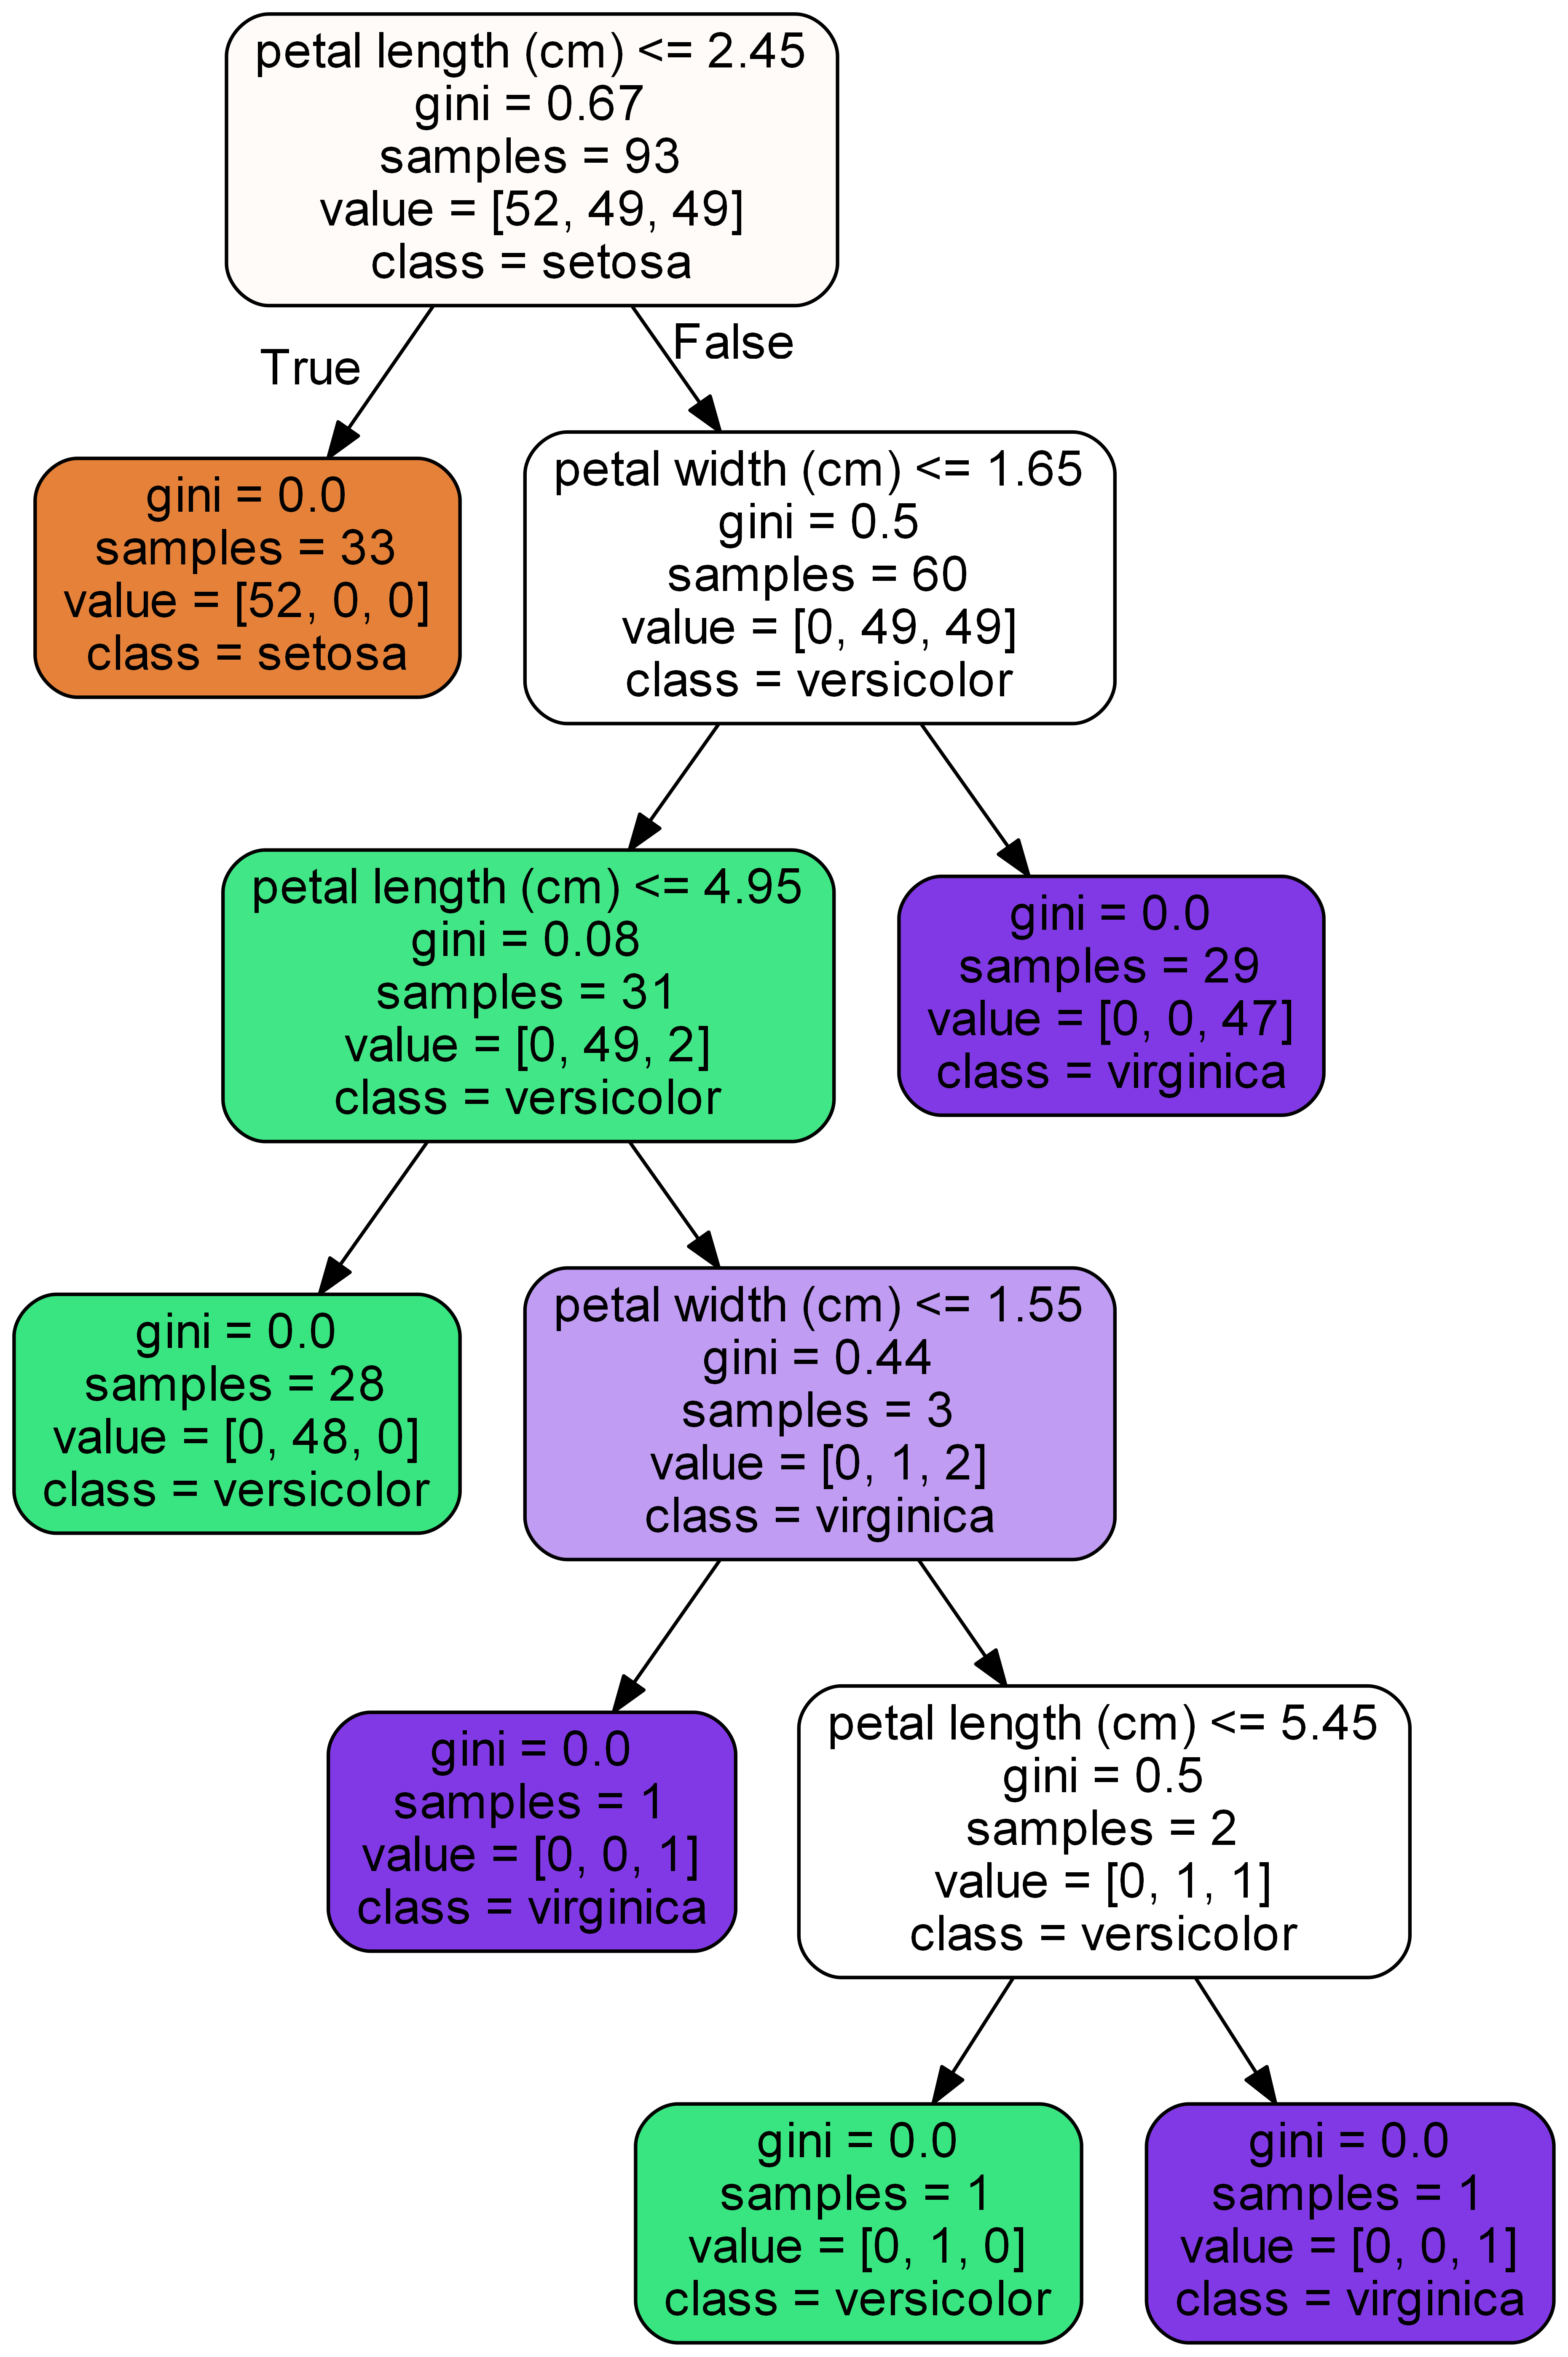

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [4]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [5]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [6]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [7]:
df.shape

(2218, 18)

In [8]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [9]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [10]:
df['n_age'] = 2021 - df.birth_year

In [11]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,57.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,34.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,57.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,30.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,29.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [12]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [14]:
df.disease.fillna(0, inplace=True)

In [15]:
df1 = df['disease'].replace(to_replace=True, value=1)

In [16]:
df1.value_counts()

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [17]:
df.global_num.fillna(round(df.global_num.mean(),2), inplace=True)
df.birth_year.fillna(round(df.birth_year.mean(),2), inplace=True)
df.infection_order.fillna(round(df.infection_order.mean(),2), inplace=True)
df.infected_by.fillna(round(df.infected_by.mean(),2), inplace=True)
df.contact_number.fillna(round(df.contact_number.mean(),2), inplace=True)


In [18]:
df.describe()

,patient_id,global_num,birth_year,infection_order,infected_by,contact_number,n_age
count,2.218000e+03,2218.000000,2218.000000,2218.000000,2.218000e+03,2218.000000,1764.000000
mean,4.014678e+09,4664.817980,1974.988936,2.289919,2.600789e+09,24.129806,46.011338
std,2.192419e+09,2211.785463,17.311232,0.170663,7.216328e+08,39.171415,19.412643
min,1.000000e+09,1.000000,1916.000000,1.000000,1.000000e+09,0.000000,1.000000
25%,1.700000e+09,4205.250000,1965.000000,2.290000,2.600789e+09,24.130000,28.000000
50%,6.001000e+09,4664.820000,1974.990000,2.290000,2.600789e+09,24.130000,46.500000
75%,6.004000e+09,5900.250000,1988.000000,2.290000,2.600789e+09,24.130000,59.000000
max,7.000000e+09,8717.000000,2020.000000,6.000000,6.113000e+09,1160.000000,105.000000


In [19]:
print(df.n_age.value_counts())
print(df.n_age.mode())

52.0     54
26.0     51
23.0     47
22.0     45
25.0     45
         ..
93.0      2
94.0      2
96.0      1
105.0     1
90.0      1
Name: n_age, Length: 96, dtype: int64
0    52.0
dtype: float64


In [20]:
print(df.age.value_counts())

20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64


**<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [21]:
#filling NAs for n_age column : Since the mode is 52 and median and mean is close to 46, I would go ahead and fill the NAs for this with Mean. Please let me know what do you think would be more appropriate option.
df.n_age.fillna(round(df.n_age.mean(),2), inplace=True)

In [22]:
#filling NA for age column : since this is not a numeric column and I see we have more cases with 20s as age, I would go ahead and fill NAs with 20s. Lemme know if you think of a better option
df.age.fillna('20s', inplace=True)

In [23]:
df.infection_case.value_counts()

contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
Pilgrimage to Israel                  1
River of Grace Community Church       1
Name: infection_case, dtype: int64

In [24]:
#Filling NAs for Infection_case : Since this is a free flow text data, filling the NAs with 'Reason Unknown'
df.infection_case.fillna('Reason Unknown', inplace=True)

In [25]:
#Filling NAs for sex column :  filling the NAs with 'Unknown'
df.sex.fillna('unknown', inplace=True)

In [26]:
df.sex.value_counts()

female     1171
male        902
unknown     145
Name: sex, dtype: int64

In [61]:
df.state.value_counts()/len(df)

isolated    0.807484
released    0.138413
missing     0.039675
deceased    0.014427
Name: state, dtype: float64

In [28]:
#Not filling anything for NA in state column as it is our taregt variable. 
# Correction : Imputing the NA in state to missing as per the below code. 
df.state.fillna('missing', inplace=True)

In [29]:
df.city.mode()

0    Gyeongsan-si
dtype: object

In [30]:
#Filling NA for city : Since the most of the cases are from "Gyeongsan-si", filling NAs with this 
df.city.fillna('Gyeongsan-si', inplace=True)

 **<font color='teal'> Check for any remaining null values.</font>**

In [31]:
#Camparing the null before and after 
na_check=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_check.columns = ['VarName', 'NullCount']
print(na_check[(na_df['NullCount']>0)])
print('------------------------')
print(na_df[(na_df['NullCount']>0)])

               VarName  NullCount
0        deceased_date       2186
1   symptom_onset_date       2025
2        released_date       1995
3       confirmed_date        141
4                n_age          0
5             province          0
6           global_num          0
7                  sex          0
8           birth_year          0
9                  age          0
10             country          0
11      infection_case          0
12                city          0
13             disease          0
14               state          0
15     infection_order          0
------------------------
               VarName  NullCount
0              disease       2199
1        deceased_date       2186
2      infection_order       2176
3   symptom_onset_date       2025
4        released_date       1995
5       contact_number       1807
6          infected_by       1749
7       infection_case       1055
8           global_num        904
9           birth_year        454
10               n_age 

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          2218 non-null   float64
 2   sex                 2218 non-null   object 
 3   birth_year          2218 non-null   float64
 4   age                 2218 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2218 non-null   object 
 8   disease             2218 non-null   object 
 9   infection_case      2218 non-null   object 
 10  infection_order     2218 non-null   float64
 11  infected_by         2218 non-null   float64
 12  contact_number      2218 non-null   float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

Remove date columns from the data.


In [33]:
# Just in case, saving the date data in a different dataframe before dropping it
df_dates_data = df[['symptom_onset_date','confirmed_date','released_date','deceased_date']]

In [34]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   int64  
 1   global_num       2218 non-null   float64
 2   sex              2218 non-null   object 
 3   birth_year       2218 non-null   float64
 4   age              2218 non-null   object 
 5   country          2218 non-null   object 
 6   province         2218 non-null   object 
 7   city             2218 non-null   object 
 8   disease          2218 non-null   object 
 9   infection_case   2218 non-null   object 
 10  infection_order  2218 non-null   float64
 11  infected_by      2218 non-null   float64
 12  contact_number   2218 non-null   float64
 13  state            2218 non-null   object 
 14  n_age            2218 non-null   float64
dtypes: float64(6), int64(1), object(8)
memory usage: 260.0+ KB


Review the count of unique values by column.

In [36]:
print(df.nunique().sort_values(ascending=False))

patient_id         2218
global_num         1304
infected_by         207
city                134
n_age                97
birth_year           97
contact_number       73
infection_case       17
province             17
age                  11
infection_order       7
state                 4
country               4
sex                   3
disease               2
dtype: int64


Review the percent of unique values by column.

In [37]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.001353
birth_year         0.043733
age                0.004959
country            0.001803
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007665
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043733
dtype: float64


Review the range of values per column.

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664818e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664820e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974990e+03,1.988000e+03,2.020000e+03
infection_order,2218.0,2.289919e+00,1.706632e-01,1.000000e+00,2.290000e+00,2.290000e+00,2.290000e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412981e+01,3.917141e+01,0.000000e+00,2.413000e+01,2.413000e+01,2.413000e+01,1.160000e+03
n_age,2218.0,4.601106e+01,1.731123e+01,1.000000e+00,3.300000e+01,4.601000e+01,5.600000e+01,1.050000e+02


### Check for duplicated rows

In [39]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


In [40]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,released,57.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,released,34.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,57.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,released,30.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,29.0


Print the categorical columns and their associated levels.

In [41]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,3
1,age,11
2,country,4
3,province,17
4,city,134
5,disease,2
6,infection_case,17
7,state,4


In [42]:
nume_data = df.select_dtypes(exclude=['object']).columns
nume_data

Index(['patient_id', 'global_num', 'birth_year', 'infection_order',
       'infected_by', 'contact_number', 'n_age'],
      dtype='object')

In [101]:
df.contact_number.value_counts()

24.13      1807
0.00         47
2.00         44
3.00         42
1.00         34
           ... 
117.00        1
1160.00       1
84.00         1
174.00        1
75.00         1
Name: contact_number, Length: 73, dtype: int64

**<font color='teal'> Plot the correlation heat map for the features.</font>**

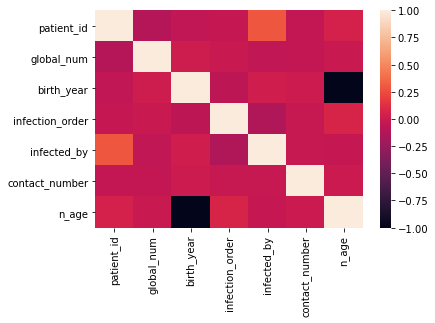

In [43]:
sns.heatmap(df.corr())

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

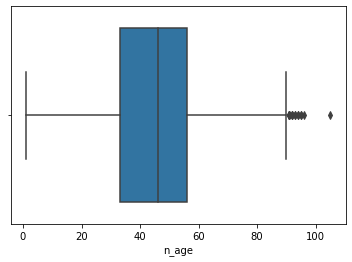

In [44]:
# I tried but could not draw the box plots for all the colums at once. Please suggest code to do that and also 
#I dont see any numerical column has an outlier that we should work on(except n_age) hence not doing anything for outliers. 


sns.boxplot(x='n_age',data=df)

In [45]:
df.state.value_counts()

isolated    1791
released     307
missing       88
deceased      32
Name: state, dtype: int64

In [64]:
y_test.value_counts()/len(y_test)

isolated    0.790541
released    0.155405
missing     0.038288
deceased    0.015766
Name: state, dtype: float64

In [232]:
#below codes are not needed now as we imputed the NAs in state to missing.
#Creating a df for Nan just in case.
#Nan_df = df[df["state"].isnull()]
#len(Nan_df)
#Now deleting the NAs from y which we did not do earlier.
#df = df.dropna(axis=0)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   int64  
 1   global_num       2218 non-null   float64
 2   sex              2218 non-null   object 
 3   birth_year       2218 non-null   float64
 4   age              2218 non-null   object 
 5   country          2218 non-null   object 
 6   province         2218 non-null   object 
 7   city             2218 non-null   object 
 8   disease          2218 non-null   object 
 9   infection_case   2218 non-null   object 
 10  infection_order  2218 non-null   float64
 11  infected_by      2218 non-null   float64
 12  contact_number   2218 non-null   float64
 13  state            2218 non-null   object 
 14  n_age            2218 non-null   float64
dtypes: float64(6), int64(1), object(8)
memory usage: 260.0+ KB


**<font color='teal'> Create dummy features for object type features. </font>**

In [103]:
#Before we create dummy variables for object type features, I would seperate the X and y from our dataframe.
#Im not sure what is the best order for creating dummy variable, selecting features, splitting the data in test and train. 
#Hence please share the best practices that you follow.

X_columns = list(df.columns)
X_columns.remove('state') 
X_columns.remove('patient_id')
X_columns.remove('global_num')


X = df[X_columns]
y = df['state']

In [104]:
#Now will create dummy variables for catagorical values in X
# Question : since our target variable y is also a multiclass feature, 
#should we also create dummies for for y. Not sure how to deal with this. 
#Also there are missing values in y which I did not impute earlier.

X = pd.get_dummies(X)


In [105]:
X.shape

(2218, 193)

In [106]:
list_cols = list(X.columns)
list_cols

['birth_year',
 'infection_order',
 'infected_by',
 'contact_number',
 'n_age',
 'sex_female',
 'sex_male',
 'sex_unknown',
 'age_0s',
 'age_100s',
 'age_10s',
 'age_20s',
 'age_30s',
 'age_40s',
 'age_50s',
 'age_60s',
 'age_70s',
 'age_80s',
 'age_90s',
 'country_China',
 'country_Korea',
 'country_Mongolia',
 'country_Thailand',
 'province_Busan',
 'province_Chungcheongbuk-do',
 'province_Chungcheongnam-do',
 'province_Daegu',
 'province_Daejeon',
 'province_Gangwon-do',
 'province_Gwangju',
 'province_Gyeonggi-do',
 'province_Gyeongsangbuk-do',
 'province_Gyeongsangnam-do',
 'province_Incheon',
 'province_Jeju-do',
 'province_Jeollabuk-do',
 'province_Jeollanam-do',
 'province_Sejong',
 'province_Seoul',
 'province_Ulsan',
 'city_Andong-si',
 'city_Ansan-si',
 'city_Anseong-si',
 'city_Anyang-si',
 'city_Asan-si',
 'city_Bonghwa-gun',
 'city_Bucheon-si',
 'city_Buk-gu',
 'city_Bupyeong-gu',
 'city_Busanjin-gu',
 'city_Changnyeong-gun',
 'city_Changwon-si',
 'city_Cheonan-si',
 'cit

In [107]:
y.shape

(2218,)

In [108]:
y.unique()

array(['released', 'isolated', 'deceased', 'missing'], dtype=object)

### Split the data into test and train subsamples

In [109]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [110]:
X_test.shape

(444, 193)

### Scale data to prep for model creation

In [111]:
#scale data 
#Question : I was under impression that for trees algorithm we dont need to scale the data as it is done feature by freature.
# Please let me know if we are scaling data because it is random forest and not just a single tree????
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [112]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [116]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
#Question : i didn't get why are we doing the below : predict_proba????
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.838
Random Forest: f1-score=0.802


In [78]:
RandomForestClassifier?

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [74]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  7   0   0   0]
 [  0 343   0   8]
 [  0   1  16   0]
 [  0  56   0  13]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.98 0.   0.02]
 [0.   0.06 0.94 0.  ]
 [0.   0.81 0.   0.19]]


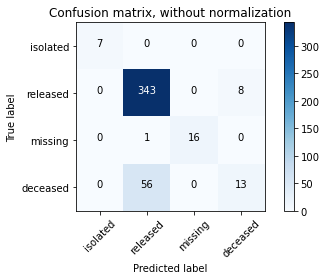

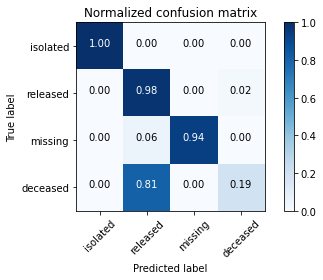

In [75]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


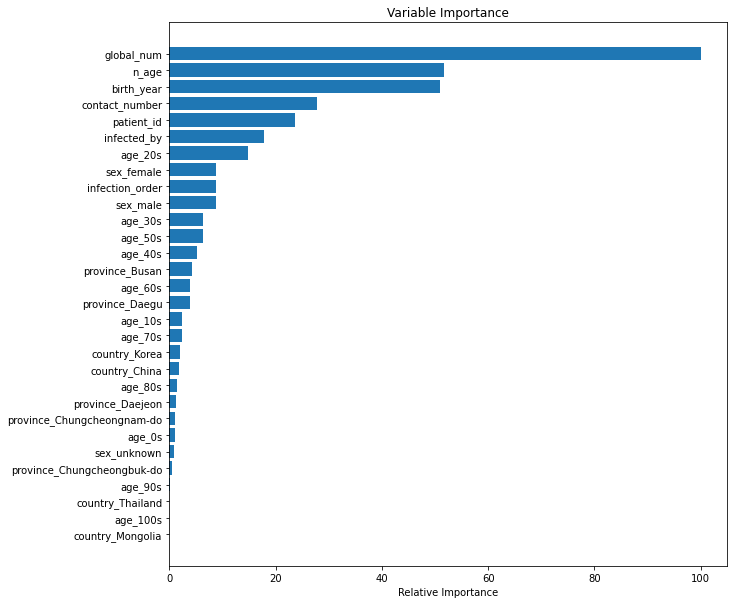

In [76]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.

In [96]:
Questions : Why does the class labels are showing incorrect???
Feature importance???
How can we imporve the accuracy further???
Best practices for dealing with class imbalances????
How do we get the best number for estimators?? is the technique called grid search????

SyntaxError: invalid syntax (<ipython-input-96-0cee7a379d99>, line 1)